This model is inspired by "Get To The Point: Summarization with Pointer-Generator Networks"
by Abigail See, Peter Liu and Christopher Manning.

- Paper: https://arxiv.org/pdf/1704.04368.pdf
- Blog Post: http://www.abigailsee.com/2017/04/16/taming-rnns-for-better-summarization.html
- Github: https://github.com/abisee/pointer-generator/blob/master/attention_decoder.py

Moreover, it employs TextRank and Maximal Marginal Relevence in selecting input sentences.

- MMR: http://www.cs.cmu.edu/afs/.cs.cmu.edu/Web/People/jgc/publication/MMR_DiversityBased_Reranking_SIGIR_1998.pdf
- TextRank: https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf

# Imports

In [1]:
from collections import Counter
from operator import itemgetter
import os
from random import shuffle
import sys

from keras import backend as K
from keras.constraints import max_norm
from keras.models import Model
from keras.layers import add, Bidirectional, concatenate, CuDNNLSTM, Dense, Dropout, \
                         Input, Lambda, Layer, multiply, Permute, RNN
from keras.utils import plot_model
import matplotlib.pyplot as plt
from nltk import sent_tokenize # NB: add
import numpy as np
import pandas as pd
from scipy.sparse import vstack
import sentencepiece as spm
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tqdm import tqdm_notebook

from utils import clean, vectorize

Using TensorFlow backend.


In [2]:
%matplotlib notebook

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14445451389670127897
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7035113779775775966
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [4]:
def pagerank(A, eps=0.0001, d=0.85):
    P = np.ones(len(A)) / len(A)
    while True:
        new_P = (1 - d) * np.ones(len(A)) / len(A) + d * A.T.dot(P)
        delta = abs(new_P - P).sum()
        if delta <= eps:
            return new_P
        P = new_P
        
        
def mmr_summarize(sentences, sentences_vectors, n_sentences=3, L=0.5):
    sentences_sim_matrix = cosine_similarity(sentences_vectors)
    # normalize row-wise
    sentences_sim_matrix /= np.sum(sentences_sim_matrix, axis=0)[:, None]
    
    sentences_textrank_probs = pagerank(sentences_sim_matrix)
    sentences_sim_penalties = np.zeros(len(sentences_textrank_probs))
    summary_sentences = []
    summary_sentences_vectors = None

    while len(summary_sentences) < n_sentences:
        sentences_scores = (L*sentences_textrank_probs-(1-L)*sentences_sim_penalties)
        sentences_ordered_indexes = np.argsort(-sentences_scores)
        sentences_ordered = itemgetter(*sentences_ordered_indexes)(sentences)
        best_sent_idx = [
            idx for idx, sentence in zip(sentences_ordered_indexes, sentences_ordered) 
#             if ((len(sentence) > 50) and (len(sentence) < 250))
        ][0]
        summary_sentences.append(sentences[best_sent_idx])

        if summary_sentences_vectors is not None:
            summary_sentences_vectors = vstack([summary_sentences_vectors, sentences_vectors[best_sent_idx]])
        else:
            summary_sentences_vectors = sentences_vectors[best_sent_idx]
        sentences_sim_penalties = (
            np.mean(cosine_similarity(sentences_vectors, summary_sentences_vectors), axis=1)
        )
        sentences_sim_penalties /= sentences_sim_penalties.sum()
    
    return summary_sentences

# Config

In [5]:
STORIES_DIR = 'data/combined/stories/'
story_files = os.listdir(STORIES_DIR)
shuffle(story_files)

In [6]:
n_files = len(story_files)
print('Stories in directory: %d' % n_files)

Stories in directory: 312085


In [7]:
MODEL_NAME = 'mds_textrank_mmr_subword_level_bidirectional_deep_lstm_seq2seq_w_attn_pointer_coverage_dropout_v1'
VOCAB_SIZE = 25000
BOS_ID = 1
EOS_ID = 2
EPOCH_START = 0
STORIES_TO_TEST = 50
STORIES_TO_TRAIN = n_files - STORIES_TO_TEST
MAX_STORY_TOKENS_TO_CONSIDER = 300
MAX_SUMMARY_TOKENS_TO_CONSIDER = 100
LSTM_LATENT_DIM = 256
VOCAB_EMBEDDING_DIM = 256
BATCH_SIZE = 50
EPOCHS = 100
BATCHES_PER_LOSSCALC = 10
BATCHES_PER_LOSSOUT = 10
BEAM_K = 5

# Generate Vocab

In [8]:
if not os.path.exists('sentencepiece'):
    os.mkdir('sentencepiece')

if not os.path.exists('sentencepiece/sp%s.vocab' % (VOCAB_SIZE-2)):
    # VOCAB_SIZE-2 because of bos and eos tokens
    story_files_str = ''
    for file in story_files:
        story_files_str += (STORIES_DIR+file+',')
    
    spm.SentencePieceTrainer.Train(
        "\
        --input=%s\
        --model_type=bpe \
        --model_prefix=sentencepiece/sp%s \
        --vocab_size=%s \
        "
        % (story_files_str, (VOCAB_SIZE-2), (VOCAB_SIZE-2))
    ) 

sp = spm.SentencePieceProcessor()
sp.Load("sentencepiece/sp%s.model" % (VOCAB_SIZE-2))

True

In [9]:
sp.SetEncodeExtraOptions('bos:eos')

True

In [10]:
tokens = []
with open('sentencepiece/sp%s.vocab' % (VOCAB_SIZE-2)) as fp:
    line = fp.readline()
    while line:
        line = line[:-1]
        token, idx = line.split('\t')
        tokens.append(token)
        line = fp.readline()

# Spot Check Inputs - Sentence Permuting/Sampling

In [11]:
print('N tokens: %d' % len(tokens))
print('Avg token len: %0.3f' % np.mean([len(token) for token in tokens]))

N tokens: 24998
Avg token len: 6.475


In [12]:
%%time
# get story and summary strings
test_stories = []
test_summaries = []
for filename in story_files[-STORIES_TO_TEST:]:
    f = open(STORIES_DIR+filename, 'r')
    combo = f.read()
    splt = combo.split('@highlight')

    story = splt[0].replace('(CNN)', '')
    # Sentence Permuting/Sampling
    sentences = sent_tokenize(story)
    sentences_vectors, _ = vectorize(sentences, lemmatize_docs=False, max_synonym_merge_dist=None)
    non_empty_sentence_indexes = [idx for idx, vector in enumerate(sentences_vectors) if np.sum(vector) > 0]
    sentences = itemgetter(*non_empty_sentence_indexes)(sentences)
    sentences_vectors = sentences_vectors[non_empty_sentence_indexes]
    sentences = mmr_summarize(sentences, sentences_vectors, n_sentences=25)
    story = ' '.join(sentences)
    test_stories.append(story)

    summary = '. '.join(splt[1:]).replace('\n', '')
    summary += '.'
    test_summaries.append(summary)

    f.close()
N = len(test_stories)

# embed stories
test_stories_embeddings = np.zeros(
    (N, MAX_STORY_TOKENS_TO_CONSIDER, VOCAB_SIZE),
    dtype='float32'
)
for i, story in enumerate(test_stories):
    story_token_ids = sp.EncodeAsIds(story)
    for j, token_id in enumerate(story_token_ids):
        if j < MAX_STORY_TOKENS_TO_CONSIDER:
            test_stories_embeddings[i, j, token_id] = 1.
        else:
            break

# embed summaries
test_summaries_embeddings_input = np.zeros(
    (N, MAX_SUMMARY_TOKENS_TO_CONSIDER, VOCAB_SIZE),
    dtype='float32'
)
test_summaries_embeddings_target = np.zeros(
    (N, MAX_SUMMARY_TOKENS_TO_CONSIDER, VOCAB_SIZE),
    dtype='float32'
)
for i, summary in enumerate(test_summaries):
    summary_token_ids = sp.EncodeAsIds(summary)
    for j, token_id in enumerate(summary_token_ids):
        if j <= MAX_SUMMARY_TOKENS_TO_CONSIDER:
            if j < MAX_SUMMARY_TOKENS_TO_CONSIDER:
                test_summaries_embeddings_input[i, j, token_id] = 1.
            if j > 0:
                test_summaries_embeddings_target[i, j-1, token_id] = 1.
        else:
            break

CPU times: user 1.87 s, sys: 500 ms, total: 2.37 s
Wall time: 2.36 s


In [13]:
for story_embedding, summary_embedding in zip(test_stories_embeddings, test_summaries_embeddings_input):
    print(sp.DecodeIds([int(np.argmax(token)) for token in story_embedding]))
    print('\n')
    print(sp.DecodeIds([int(np.argmax(token)) for token in summary_embedding]))
    print('\n\n\n')

Undercover police officer Jim Boyling, also known as Jim Sutton was part of the covert surveillance squad So far 12 woman have lodged cases against the Met over the actions of its undercover surveillance officers Mr Carey told them:  ⁇ The Metropolitan Police are prepared to criticise the conduct of an individual officer, Bob Lambert. We regret if this necessarily complex process has added to her distress.  ⁇ We want to be, and have tried hard to be, as open as we possibly can. From the outset we have dealt with this lengthy case with professionalism and sensitivity, completely understanding the gravity of the circumstances. There were nearly 150 of them, so it would not be unreasonable to suggest there are many more out there who don't realise they are victims.' A Scotland Yard spokesman said the force  ⁇ unreservedly apologises for any pain and suffering that the relationship with Bob Lambert, an undercover officer, has had on this woman ⁇  but said that it had  ⁇ never had a policy 

A Consumer Rights Bill amendment will be debated next week. Opposed by retailers, David Cameron says there's no need to change law. Pizza Express, KFC and Subway selling halal meat, it has been revealed. Halal and kosher slaughter involve a religious ritual in which throat is cut. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 




'Like a piece of raw meat': Fabio Smith's foot was badly injured when his leg went into a drain filled with toxic chemicals at his school Painful: Fabio with his mother Nikita at their home in Llanishen, Cardiff, South Wales, after the incident at primary school Nikita Payne said Fabio's foot looked like 'raw meat' after he stepped in to the uncovered drain during playtime at his primary school. 'He's going to be permanently scarred and I'm also worried about what psychological scars he'll be left with after seeing the hospital peel off his skin. 'You don't expect this to happen in a playground of all pla

Only those members who produced their own child pornography could be granted the status of Super VIP Dot," Breuer explained. Holder said, "Some of the children featured in these images and videos were just infants and in many cases, the children being victimized were in obvious and also intentional pain, even in distress and crying, just as the rules for one area of the bulletin board mandated. An additional 10 individuals were arrested abroad on charges from other countries. CNN's Senior Producer Jim Barnett contributed to this report. Those sentenced are from Illinois, Alabama, Florida and Kentucky. John Morton, the head of ICE, said the day marked a law enforcement "success" but was nonetheless a "sad" day because of the nature of the crimes involved. Seventy-two members of the online site called Dreamboard have been charged in the United States. The three others have not yet been identified by agents following the case and remain at large. The identities of the remaining 20 are unk

# Get Recent Real Top Substory Clusters for Testing

In [14]:
from datetime import datetime, timedelta

from bson.objectid import ObjectId
from bson.son import SON
from pymongo import MongoClient

import configs


#MongoDB Config
MDB_CLIENT = MongoClient(configs.MDB_HOST)

MILLI_MDB = MDB_CLIENT.milli_mdb
PARSED_CONTENT = MILLI_MDB.parsed_content

SORTINGHAT_MDB = MDB_CLIENT.sortinghat_mdb
CONTENT_CLUSTERS = SORTINGHAT_MDB.content_clusters


# From Hedwig:
def get_clusters_structure(region_classification, topic_classification, batch_type):
    """
    Queries MongoDB for most recent yet stable cluster batch(es), then returns a
        (sorted) story_clusters object containing corresponding story and substory
        clusters.

    Keyword arguments:
    region_classification - filter on field of same name in content_clusters (str or dict/pymongo filter)
    topic_classification - filter on field of same name in content_clusters (str or dict/pymongo filter)
    batch_type - filter on field of same name in content_clusters (str or dict/pymongo filter)

    Returns:
    list - in the format [{'story_cluster_id': str(s),
                           'substory_clusters': [sc],
                           'peer_score': int(p)}, ...],
        where [sc] in the format [{'substory_cluster_id': str(s),
                                   'n_articles': int(n),
                                   'min_crawl_time': datetime(m),
                                   'peer_score': int(p),
                                   'object_ids': [oi]}, ...]
       and where each list is sorted in descending order by peer_score.
    """
    # get recently formed but stable cluster batches
    consideration_start_timestamp = (datetime.utcnow()
                                     - timedelta(hours=24))
    batch_last_write_timestamp = (datetime.utcnow()
                                  - timedelta(minutes=5))
    pipeline = [
        # consider batches formed in the last half day
        {'$match': {'batch_timestamp':{'$gt': consideration_start_timestamp},
                    'region_classification': region_classification,
                    'topic_classification': topic_classification,
                    'batch_type': batch_type}},
        # for each batch, get the most recent write time in DB
        {'$group':{'_id': {'region_classification': '$region_classification',
                           'topic_classification': '$topic_classification',
                           'batch_timestamp': '$batch_timestamp'},
                   'most_recent_write': {'$max': '$create_timestamp'}}},
        # prune those batches which have been written to in the last 5 minutes
        {'$match': {'most_recent_write':{'$lt': batch_last_write_timestamp}}},
        # among remaining batches, find the most recent for each topic
        {'$group':{'_id': {'region_classification': '$_id.region_classification',
                           'topic_classification': '$_id.topic_classification'},
                  'most_recent_batch': {'$max': '$_id.batch_timestamp'}}},
        {'$sort': SON([('_id', 1)])}
    ]
    most_recent_batches = list(CONTENT_CLUSTERS.aggregate(pipeline))

    # form corresponding clusters
    batch_filter = []
    for batch in most_recent_batches:
        new_batch = batch['_id']
        new_batch['batch_timestamp'] = batch['most_recent_batch']
        batch_filter.append(new_batch)
    batch_filter = {'$or': batch_filter}

    story_clusters = {}
    for cluster in CONTENT_CLUSTERS.find(batch_filter):
        if cluster['is_misc']:
            continue
        story_cluster_id = cluster['story_cluster_id']
        if story_cluster_id not in story_clusters:
            story_clusters[story_cluster_id] = {
                'story_cluster_id': story_cluster_id,
                'substory_clusters': [],
                'peer_score': 0
            }
        substory_cluster_id = cluster['substory_cluster_id']
        story_clusters[story_cluster_id]['peer_score'] += cluster['n_articles']
        story_clusters[story_cluster_id]['substory_clusters'].append({
            'substory_cluster_id': substory_cluster_id,
            'n_articles': cluster['n_articles'],
            'min_crawl_time': cluster['min_crawl_time'],
            'peer_score': cluster['n_articles'],
            'member_ids': cluster['member_ids']
        })

    # sort clusters structure
    story_clusters = [content for content in story_clusters.values()]
    story_clusters = sorted(story_clusters, key = lambda x: -x['peer_score'])
    for cluster in story_clusters:
        substory_clusters = cluster['substory_clusters']
        substory_clusters = sorted(substory_clusters, key = lambda x: -x['peer_score'])

    return story_clusters

In [15]:
story_clusters = get_clusters_structure('U.S. & Canada', 'Politics, Policy & Economics', 'recent 2d')

In [16]:
recent_top_substory_clusters = []
for i in range(5):
    members = story_clusters[i]['substory_clusters'][0]['member_ids'].split(', ')
    members = [ObjectId(member) for member in members]

    start_timestamp = str(datetime.utcnow()
                          - timedelta(days=8))
    content_cursor = PARSED_CONTENT.find(
        {'crawled_timestamp':{'$gt':start_timestamp},
         '_id':{'$in':members},
         }
    )

    titles = []
    texts = []
    urls = []
    for article in content_cursor:
        titles += [article['title']]
        texts += [article['text']]
        urls += [article['url']]

    texts_sentences = [sent_tokenize(text.replace('\n', ' ')) for text in texts]
    combined_sentences = []
    sentence_text_positions = {}

    for text in texts_sentences:
        n_sentences = len(text)
        for idx, sentence in enumerate(text):
            combined_sentences.append(sentence)
            sentence_text_positions[sentence] = idx/n_sentences

    combined_sentences_vectors, _ = vectorize(combined_sentences, lemmatize_docs=False, max_synonym_merge_dist=None)

    non_empty_sentence_indexes = [idx for idx, vector in enumerate(combined_sentences_vectors) if np.sum(vector) > 0]
    combined_sentences = itemgetter(*non_empty_sentence_indexes)(combined_sentences)
    combined_sentences_vectors = combined_sentences_vectors[non_empty_sentence_indexes]

    selected_sentences = mmr_summarize(combined_sentences, combined_sentences_vectors, n_sentences=25)
    selected_sentences = ' '.join(selected_sentences)
    
    # embed stories
    selected_sentences_embedding = np.zeros(
        (1, MAX_STORY_TOKENS_TO_CONSIDER, VOCAB_SIZE),
        dtype='float32'
    )

    story_token_ids = sp.EncodeAsIds(selected_sentences)
    for j, token_id in enumerate(story_token_ids):
        if j < MAX_STORY_TOKENS_TO_CONSIDER:
            selected_sentences_embedding[0, j, token_id] = 1.
        else:
            break
    
    recent_top_substory_clusters.append(
        {'titles': titles[:10],
         'selected_sentences': selected_sentences,
         'selected_sentences_embedding': selected_sentences_embedding}
    )

# Generate Models

## Training

In [17]:
class GenAttentionWeightsCell(Layer):
    def __init__(self, encoder_tokens, **kwargs):
        self.encoder_tokens = encoder_tokens
        self.state_size = encoder_tokens
        self.output_size = encoder_tokens
        super(GenAttentionWeightsCell, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.attention_weights_kernel = self.add_weight(
            shape=(self.encoder_tokens*2, self.encoder_tokens),
            initializer='uniform',
            name='attention_weights_kernel'
        )
        self.attention_weights_bias = self.add_weight(
            shape=(1, self.encoder_tokens),
            initializer='zeros',
            name='attention_weights_bias'
        )
        self.built = True
    
    def call(self, inputs, coverage_states):
        coverage_state = coverage_states[0]
        attention_weights_inputs = concatenate([inputs, coverage_state])
        attention_weights_inputs = (K.dot(attention_weights_inputs, 
                                          self.attention_weights_kernel)
                                    + self.attention_weights_bias)
        attention_weights = K.softmax(attention_weights_inputs)
        coverage_state += attention_weights
        return attention_weights, [coverage_state]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2])

In [18]:
# encoder inputs
encoder_inputs = Input(shape=(MAX_STORY_TOKENS_TO_CONSIDER, VOCAB_SIZE),
                       name='encoder_inputs')
encoder_inputs_embedded_gen = Dense(
    VOCAB_EMBEDDING_DIM, 
    name='encoder_inputs_embedding',
    kernel_constraint=max_norm(3.)
)
encoder_inputs_embedded = encoder_inputs_embedded_gen(encoder_inputs)

# lstm encoder
encoder_1 = Bidirectional(CuDNNLSTM(
    units=LSTM_LATENT_DIM,
    return_sequences=True,
    return_state=True,
    name='encoder_1',
    kernel_constraint=max_norm(3.)
))
encoder_1_outputs = encoder_1(encoder_inputs_embedded)
encoder_1_out_sequence = encoder_1_outputs[0]
encoder_1_state_h_f, encoder_1_state_c_f = encoder_1_outputs[1:3]
encoder_1_state_h_r, encoder_1_state_c_r = encoder_1_outputs[3:5]
encoder_1_state_h = concatenate([encoder_1_state_h_f, encoder_1_state_h_r], name='encoder_1_state_h')
encoder_1_state_h = Dropout(0.5, name='encoder_1_state_h_drop')(encoder_1_state_h)
encoder_1_state_c = concatenate([encoder_1_state_c_f, encoder_1_state_c_r], name='encoder_1_state_c')
encoder_1_state_c = Dropout(0.5, name='encoder_1_state_c_drop')(encoder_1_state_c)
encoder_1_states = [encoder_1_state_h, encoder_1_state_c]
encoder_1_out_sequence = Dropout(0.5, name='encoder_1_out_sequence_drop')(encoder_1_out_sequence)

encoder_2 = Bidirectional(CuDNNLSTM(
    units=LSTM_LATENT_DIM,
    return_sequences=True,
    return_state=True,
    name='encoder_2',
    kernel_constraint=max_norm(3.)
))
encoder_2_outputs = encoder_2(encoder_1_out_sequence)
encoder_2_out_sequence = encoder_2_outputs[0]
encoder_2_state_h_f, encoder_2_state_c_f = encoder_2_outputs[1:3]
encoder_2_state_h_r, encoder_2_state_c_r = encoder_2_outputs[3:5]
encoder_2_state_h = concatenate([encoder_2_state_h_f, encoder_2_state_h_r], name='encoder_2_state_h')
encoder_2_state_h = Dropout(0.5, name='encoder_2_state_h_drop')(encoder_2_state_h)
encoder_2_state_c = concatenate([encoder_2_state_c_f, encoder_2_state_c_r], name='encoder_2_state_c')
encoder_2_state_c = Dropout(0.5, name='encoder_2_state_c_drop')(encoder_2_state_c)
encoder_2_states = [encoder_2_state_h, encoder_2_state_c]
encoder_2_out_sequence = Dropout(0.5, name='encoder_2_out_sequence_drop')(encoder_2_out_sequence)

# decoder inputs
decoder_inputs = Input(shape=(None, VOCAB_SIZE),
                       name='decoder_inputs')
decoder_inputs_embedded_gen = Dense(
    VOCAB_EMBEDDING_DIM, 
    name='decoder_inputs_embedding',
    kernel_constraint=max_norm(3.)
)
decoder_inputs_embedded = decoder_inputs_embedded_gen(decoder_inputs)

# lstm decoder
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_1 = CuDNNLSTM(
    units=LSTM_LATENT_DIM*2, # encoder output is bidirectional/concatenated
    return_sequences=True,
    return_state=True,
    name='decoder_1',
    kernel_constraint=max_norm(3.)
)
decoder_1_out_sequence, decoder_1_state_h, decoder_1_state_c = decoder_1(
    decoder_inputs_embedded,
    initial_state=encoder_1_states
)
# decoder_1_out_sequence = Dropout(0.5, name='decoder_1_out_sequence_drop')(decoder_1_out_sequence)

decoder_2 = CuDNNLSTM(
    units=LSTM_LATENT_DIM*2,
    return_sequences=True, 
    return_state=True,
    name='decoder_2',
    kernel_constraint=max_norm(3.)
)
decoder_2_out_sequence, decoder_2_state_h, decoder_2_state_c = decoder_2(
    decoder_1_out_sequence,
    initial_state=encoder_2_states
)
# decoder_2_out_sequence = Dropout(0.5, name='decoder_2_out_sequence_drop')(decoder_2_out_sequence)

# attention mechanism with coverage memory
decoder_2_out_sequence_dense_gen = Dense(
    LSTM_LATENT_DIM*2,
    name='decoder_2_out_sequence_dense',
    kernel_constraint=max_norm(3.)
)
decoder_2_out_sequence_dense = decoder_2_out_sequence_dense_gen(decoder_2_out_sequence)
encoder_2_out_sequence_T_gen = Permute((2, 1), name='encoder_2_out_sequence_T')
encoder_2_out_sequence_T = encoder_2_out_sequence_T_gen(encoder_2_out_sequence)
attention_weights_inputs_gen = Lambda(
    lambda x: K.batch_dot(x[0], x[1]),
    name='attention_weights_inputs'
)
attention_weights_inputs = attention_weights_inputs_gen([decoder_2_out_sequence_dense, encoder_2_out_sequence_T])
gen_attention_weights_cell = GenAttentionWeightsCell(
    encoder_tokens=int(encoder_inputs.shape[1])
)
attention_weights_p_gen = RNN(
    cell=gen_attention_weights_cell,
    return_sequences=True,
    return_state=True,
    name='attention_weights_p'
)
attention_weights_c_gen = RNN(
    cell=gen_attention_weights_cell,
    return_sequences=True,
    return_state=True,
    name='attention_weights_c'
)
# We don't use the returned coverage state in this training model, but
# will use it in inference.
# attention weights for generation
attention_weights_p, coverage_p = attention_weights_p_gen(
    attention_weights_inputs,
    initial_state=[K.zeros((K.shape(attention_weights_inputs)[0],
                            MAX_STORY_TOKENS_TO_CONSIDER))]
)
# attention weights for copying (pointer mechanism)
attention_weights_c, coverage_c = attention_weights_c_gen(
    attention_weights_inputs,
    initial_state=[K.zeros((K.shape(attention_weights_inputs)[0],
                            MAX_STORY_TOKENS_TO_CONSIDER))]
)

# produce new token distribution
produce_new_token_context_gen = Lambda(
    lambda x: K.batch_dot(x[0], x[1]),
    name='produce_new_token_context'
)
produce_new_token_context = produce_new_token_context_gen([attention_weights_p, encoder_2_out_sequence])
produce_new_token_inputs = concatenate([decoder_2_out_sequence, produce_new_token_context], 
                                       name='produce_new_token_inputs')
produce_new_token_dist_gen = Dense(
    units=VOCAB_SIZE, 
    activation='softmax',
    name='produce_new_token_dist',
    kernel_constraint=max_norm(3.)
)
produce_new_token_dist = produce_new_token_dist_gen(produce_new_token_inputs)

# copy from source inputs token distribution
copy_input_token_dist_gen = Lambda(
    lambda x: K.batch_dot(x[0], x[1]),
    name='copy_input_token_dist'
)
copy_input_token_dist = copy_input_token_dist_gen([attention_weights_c, encoder_inputs])

# produce vs copy token pointer mechanism
produce_new_token_gate_gen = Dense(
    units=1, 
    activation='sigmoid', 
    name='produce_new_token_gate'
) 
produce_new_token_gate = produce_new_token_gate_gen(produce_new_token_inputs)
copy_input_token_gate_gen = Lambda(lambda x: 1-x, name='copy_input_token_gate')
copy_input_token_gate = copy_input_token_gate_gen(produce_new_token_gate)

weighted_produce_new_token_dist = multiply(
    [produce_new_token_dist, produce_new_token_gate],
    name='weighted_produce_new_token_dist'
)

weighted_copy_input_token_dist = multiply(
    [copy_input_token_dist, copy_input_token_gate],
    name='weighted_copy_input_token_dist'
)

# output distribution
combined_token_dist = add(
    [weighted_produce_new_token_dist, weighted_copy_input_token_dist],
    name='combined_token_dist'
)

model = Model([encoder_inputs, decoder_inputs], combined_token_dist)

In [19]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [20]:
plot_model(model, to_file=(MODEL_NAME+'.png'))

In [21]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 300, 25000)   0                                            
__________________________________________________________________________________________________
encoder_inputs_embedding (Dense (None, 300, 256)     6400256     encoder_inputs[0][0]             
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 300, 512), ( 1052672     encoder_inputs_embedding[0][0]   
__________________________________________________________________________________________________
encoder_1_out_sequence_drop (Dr (None, 300, 512)     0           bidirectional_1[0][0]            
__________________________________________________________________________________________________
decoder_in

## Inference

In [22]:
inf_encoder_model = Model(encoder_inputs, [encoder_2_out_sequence] + encoder_1_states + encoder_2_states)

In [23]:
print(inf_encoder_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 300, 25000)   0                                            
__________________________________________________________________________________________________
encoder_inputs_embedding (Dense (None, 300, 256)     6400256     encoder_inputs[0][0]             
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 300, 512), ( 1052672     encoder_inputs_embedding[0][0]   
__________________________________________________________________________________________________
encoder_1_out_sequence_drop (Dr (None, 300, 512)     0           bidirectional_1[0][0]            
__________________________________________________________________________________________________
bidirectio

In [24]:
plot_model(inf_encoder_model, to_file=(MODEL_NAME+'_inf_encoder.png'))

In [25]:
inf_decoder_inputs_embedded = decoder_inputs_embedded_gen(decoder_inputs)

inf_decoder_1_input_state_h = Input(shape=(LSTM_LATENT_DIM*2,))
inf_decoder_1_input_state_c = Input(shape=(LSTM_LATENT_DIM*2,))
inf_decoder_1_input_states = [inf_decoder_1_input_state_h, inf_decoder_1_input_state_c]
inf_decoder_1_out_sequence, inf_decoder_1_state_h, inf_decoder_1_state_c = decoder_1(
    inf_decoder_inputs_embedded, initial_state=inf_decoder_1_input_states
)
inf_decoder_1_states = [inf_decoder_1_state_h, inf_decoder_1_state_c]

inf_decoder_2_input_state_h = Input(shape=(LSTM_LATENT_DIM*2,))
inf_decoder_2_input_state_c = Input(shape=(LSTM_LATENT_DIM*2,))
inf_decoder_2_input_states = [inf_decoder_2_input_state_h, inf_decoder_2_input_state_c]
inf_decoder_2_out_sequence, inf_decoder_2_state_h, inf_decoder_2_state_c = decoder_2(
    inf_decoder_1_out_sequence, initial_state=inf_decoder_2_input_states
)
inf_decoder_2_states = [inf_decoder_2_state_h, inf_decoder_2_state_c]

inf_decoder_2_out_sequence_dense = decoder_2_out_sequence_dense_gen(inf_decoder_2_out_sequence)
inf_encoder_2_out_sequence = Input(shape=(None, LSTM_LATENT_DIM*2))
inf_encoder_2_out_sequence_T = encoder_2_out_sequence_T_gen(inf_encoder_2_out_sequence)
inf_attention_weights_inputs = attention_weights_inputs_gen(
    [inf_decoder_2_out_sequence_dense, inf_encoder_2_out_sequence_T]
)
inf_attention_weights_p_coverage_state_input = Input(shape=(MAX_STORY_TOKENS_TO_CONSIDER,))
inf_attention_weights_p, inf_coverage_p = attention_weights_p_gen(
    inf_attention_weights_inputs,
    initial_state=[inf_attention_weights_p_coverage_state_input]
)
inf_attention_weights_c_coverage_state_input = Input(shape=(MAX_STORY_TOKENS_TO_CONSIDER,))
inf_attention_weights_c, inf_coverage_c = attention_weights_c_gen(
    inf_attention_weights_inputs,
    initial_state=[inf_attention_weights_c_coverage_state_input]
)

inf_produce_new_token_context = produce_new_token_context_gen([inf_attention_weights_p, inf_encoder_2_out_sequence])
inf_produce_new_token_inputs = concatenate([inf_decoder_2_out_sequence, inf_produce_new_token_context])
inf_produce_new_token_dist = produce_new_token_dist_gen(inf_produce_new_token_inputs)

inf_encoder_inputs = Input(shape=(MAX_STORY_TOKENS_TO_CONSIDER, VOCAB_SIZE))
inf_copy_input_token_dist = copy_input_token_dist_gen([inf_attention_weights_c, inf_encoder_inputs])

inf_produce_new_token_gate = produce_new_token_gate_gen(inf_produce_new_token_inputs)
inf_copy_input_token_gate = copy_input_token_gate_gen(inf_produce_new_token_gate)

inf_weighted_produce_new_token_dist = multiply([inf_produce_new_token_dist, inf_produce_new_token_gate])

inf_weighted_copy_input_token_dist = multiply([inf_copy_input_token_dist, inf_copy_input_token_gate])

inf_combined_token_dist = add([inf_weighted_produce_new_token_dist, inf_weighted_copy_input_token_dist])

inf_decoder_model = Model(
    [decoder_inputs, inf_encoder_2_out_sequence, inf_encoder_inputs] 
        + inf_decoder_1_input_states 
        + inf_decoder_2_input_states
        + [inf_attention_weights_p_coverage_state_input]
        + [inf_attention_weights_c_coverage_state_input],
    [inf_combined_token_dist] + inf_decoder_1_states + inf_decoder_2_states + [inf_coverage_p] + [inf_coverage_c]
)

In [26]:
print(inf_decoder_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     (None, None, 25000)  0                                            
__________________________________________________________________________________________________
decoder_inputs_embedding (Dense (None, None, 256)    6400256     decoder_inputs[0][0]             
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
decoder_1 

In [27]:
plot_model(inf_decoder_model, to_file=(MODEL_NAME+'_inf_decoder.png'))

In [28]:
def get_summary(input_seq, beam_k):
    # Encode the input as state vectors.
    encoded_seq, h1, c1, h2, c2 = inf_encoder_model.predict(input_seq)
    states_1_value = [h1, c1]
    states_2_value = [h2, c2]

    # Generate empty target sequence of length 1.
    decoder_input = np.zeros((1, 1, VOCAB_SIZE))
    # Populate the first character of target sequence with the start character.
    decoder_input[0, 0, BOS_ID] = 1.
    
    coverage_state_p = [np.zeros((1, MAX_STORY_TOKENS_TO_CONSIDER))]
    coverage_state_c = [np.zeros((1, MAX_STORY_TOKENS_TO_CONSIDER))]

    # Beam search for sequence summary
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    candidate_sentences = [{'encoding': [],
                            'len': 0,
                            'is_complete': False,
                            'decoder_input': decoder_input,
                            'states_1_value': states_1_value, 
                            'states_2_value': states_2_value,
                            'coverage_state_p': coverage_state_p,
                            'coverage_state_c': coverage_state_c,
                            'log_prob': 1.0}] # use log prob since conditional probs become tiny
    while not stop_condition:
        tmp_candidate_sentences = []
        for candidate in candidate_sentences:
            if candidate['is_complete']:
                tmp_candidate_sentences.append(candidate)
            else:
                output_probs, h1, c1, h2, c2, coverage_p, coverage_c = inf_decoder_model.predict(
                    [candidate['decoder_input'], encoded_seq, input_seq]
                    + candidate['states_1_value'] 
                    + candidate['states_2_value']
                    + candidate['coverage_state_p']
                    + candidate['coverage_state_c']
                )
                # Reduce dimensionality
                output_probs = output_probs[0, 0, :]
                # since only k-best sentences are considered globally, at most need to
                # consider the k-best locally:
                sampled_token_indexes = np.argpartition(output_probs, -beam_k)[-beam_k:]
                for idx in sampled_token_indexes:
                    encoding = (candidate['encoding'] + [int(idx)])
                    sent_len = (candidate['len'] + 1)
                    # summary is complete when end character is generated or max length reached
                    is_complete = (idx == EOS_ID
                                   or sent_len == MAX_SUMMARY_TOKENS_TO_CONSIDER)
                    decoder_input = np.zeros((1, 1, VOCAB_SIZE))
                    decoder_input[0, 0, idx] = 1.
                    states_1_value = [h1, c1]
                    states_2_value = [h2, c2]
                    coverage_state_p = [coverage_p]
                    coverage_state_c = [coverage_c]
                    log_prob = (candidate['log_prob'] + np.log(output_probs[idx]))
                    new_candidate = {
                        'encoding': encoding, 
                        'len': sent_len,
                        'is_complete': is_complete,
                        'decoder_input': decoder_input,
                        'states_1_value': states_1_value, 
                        'states_2_value': states_2_value, 
                        'coverage_state_p': coverage_state_p,
                        'coverage_state_c': coverage_state_c,
                        'log_prob': log_prob
                    }
                    tmp_candidate_sentences.append(new_candidate)
        tmp_candidate_sentences = sorted(tmp_candidate_sentences, 
                                         key = lambda candidate: candidate['log_prob'])
        candidate_sentences = tmp_candidate_sentences[-beam_k:]
        
        # stop loop when all candidate sentences are complete
        stop_condition = True
        for candidate in candidate_sentences:
            stop_condition = (stop_condition and candidate['is_complete'])

    
    return sp.DecodeIds(candidate_sentences[-1]['encoding']), candidate_sentences

# Model Training

In [29]:
if EPOCH_START > 0: 
    model.load_weights(MODEL_NAME+'_weights_'+str(EPOCH_START-1)+'.h5')

<IPython.core.display.Javascript object>


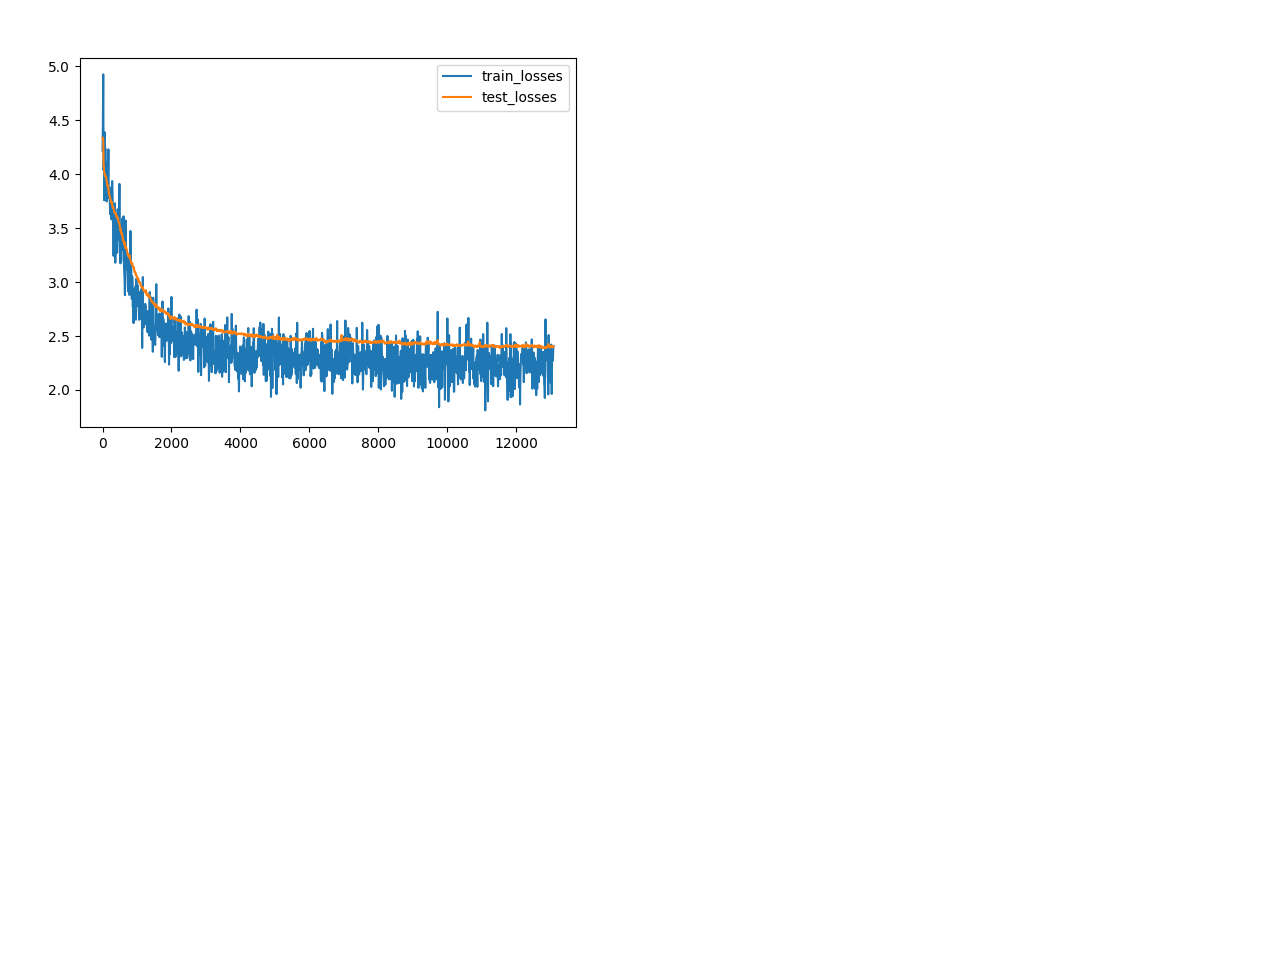


Epoch 0:






Training Stories Spot Check

Story:
Editor's Note: Actress Drew Barrymore is an Ambassador Against Hunger for the U.N.' s World Food Program. One person's quarter can fill a child's cup. A problem that had seemed so vast, so untouchable to me, suddenly felt smaller and more contained -- at least for the moment. It was incredible to be on "Oprah" donating $1 million to WFP; but my heart was lifted so much higher when I saw the donations that followed from inspired students, working adults, mothers, fathers, daughters, people all across the United States, giving what they could to additionally raise over $500,000 that will fill the cups of children in WFP schools across the globe. Josette and I banded together again at the Clinton Global Initiative, where school feeding programs were brought to the forefront. That was my first trip and I came back knowing that this was for me. I took my documentary crew with me; we spent a couple of weeks in Kenya. I was given an opportunity to sit i


Story:
Undercover police officer Jim Boyling, also known as Jim Sutton was part of the covert surveillance squad

So far 12 woman have lodged cases against the Met over the actions of its undercover surveillance officers 

Mr Carey told them: ‘The Metropolitan Police are prepared to criticise the conduct of an individual officer, Bob Lambert. We regret if this necessarily complex process has added to her distress. ‘We want to be, and have tried hard to be, as open as we possibly can. From the outset we have dealt with this lengthy case with professionalism and sensitivity, completely understanding the gravity of the circumstances. There were nearly 150 of them, so it would not be unreasonable to suggest there are many more out there who don't realise they are victims.' A Scotland Yard spokesman said the force ‘unreservedly apologises for any pain and suffering that the relationship with Bob Lambert, an undercover officer, has had on this woman’ but said that it had ‘never had a policy


Titles:
['Trump knew hush-money payments were wrong, Cohen says Video', 'Michael Cohen launches into president in explosive first interview since sentencing', 'Ex-lawyer Cohen: Trump knew hush payments were wrong – ABC News', "Donald Trump 'knew it was wrong' to pay hush money to women, says ex-lawyer Michael Cohen", 'Michael Cohen: Donald Trump Knew Hush Money Payments Were Wrong', 'Ex-lawyer Cohen: Trump knew hush payments were wrong - ABC News', 'Ex-lawyer Cohen - Trump knew hush payments were wrong: ABC News', 'Trump knew hush-money payments were wrong: ex-lawyer Cohen', 'Trump knew hush-money payments were wrong: ex-lawyer Cohen', 'Trump knew hush-money payments were wrong: ex-lawyer Cohen']

Generated Summaries:


Trump has said he never directed Cohen to break the law Trump acted because he "was very concerned about how this would affect the election," Cohen says. News of the women's allegations in his first comments since being sentenced to three years in prison on Thursday. P





Training Stories Spot Check

Story:
Editor's Note: Actress Drew Barrymore is an Ambassador Against Hunger for the U.N.' s World Food Program. One person's quarter can fill a child's cup. A problem that had seemed so vast, so untouchable to me, suddenly felt smaller and more contained -- at least for the moment. It was incredible to be on "Oprah" donating $1 million to WFP; but my heart was lifted so much higher when I saw the donations that followed from inspired students, working adults, mothers, fathers, daughters, people all across the United States, giving what they could to additionally raise over $500,000 that will fill the cups of children in WFP schools across the globe. Josette and I banded together again at the Clinton Global Initiative, where school feeding programs were brought to the forefront. That was my first trip and I came back knowing that this was for me. I took my documentary crew with me; we spent a couple of weeks in Kenya. I was given an opportunity to sit i


Story:
Undercover police officer Jim Boyling, also known as Jim Sutton was part of the covert surveillance squad

So far 12 woman have lodged cases against the Met over the actions of its undercover surveillance officers 

Mr Carey told them: ‘The Metropolitan Police are prepared to criticise the conduct of an individual officer, Bob Lambert. We regret if this necessarily complex process has added to her distress. ‘We want to be, and have tried hard to be, as open as we possibly can. From the outset we have dealt with this lengthy case with professionalism and sensitivity, completely understanding the gravity of the circumstances. There were nearly 150 of them, so it would not be unreasonable to suggest there are many more out there who don't realise they are victims.' A Scotland Yard spokesman said the force ‘unreservedly apologises for any pain and suffering that the relationship with Bob Lambert, an undercover officer, has had on this woman’ but said that it had ‘never had a policy


Titles:
['Trump knew hush-money payments were wrong, Cohen says Video', 'Michael Cohen launches into president in explosive first interview since sentencing', 'Ex-lawyer Cohen: Trump knew hush payments were wrong – ABC News', "Donald Trump 'knew it was wrong' to pay hush money to women, says ex-lawyer Michael Cohen", 'Michael Cohen: Donald Trump Knew Hush Money Payments Were Wrong', 'Ex-lawyer Cohen: Trump knew hush payments were wrong - ABC News', 'Ex-lawyer Cohen - Trump knew hush payments were wrong: ABC News', 'Trump knew hush-money payments were wrong: ex-lawyer Cohen', 'Trump knew hush-money payments were wrong: ex-lawyer Cohen', 'Trump knew hush-money payments were wrong: ex-lawyer Cohen']

Generated Summaries:


President Donald Trump has said he never directed Cohen to break the law Trump acted because he "was very concerned about how this would affect the election election," Cohen says. Cohen told ABC News of the women's allegations in his first comments since being sentence

KeyboardInterrupt: 

In [30]:
batch = 0
batches = []
train_losses = []
test_losses = []

fig = plt.figure()
subplt = fig.add_subplot(111)
fig.show()
fig.canvas.draw()

for epoch in np.arange(EPOCH_START, EPOCHS):
    print('\nEpoch %d:' % epoch)
    for start_file_idx in tqdm_notebook(np.arange(0, STORIES_TO_TRAIN, BATCH_SIZE)):
        end_file_idx = min(start_file_idx+BATCH_SIZE, STORIES_TO_TRAIN)

        # get story and summary strings
        stories = []
        summaries = []
        for filename in story_files[start_file_idx:end_file_idx]:
            f = open(STORIES_DIR+filename, 'r')
            combo = f.read()
            splt = combo.split('@highlight')

            story = splt[0].replace('(CNN)', '')
            # Sentence Permuting/Sampling
            sentences = sent_tokenize(story)
            if not sentences:
                continue
            sentences_vectors, _ = vectorize(sentences, lemmatize_docs=False, max_synonym_merge_dist=None)
            non_empty_sentence_indexes = [idx for idx, vector in enumerate(sentences_vectors) if np.sum(vector) > 0]
            sentences = itemgetter(*non_empty_sentence_indexes)(sentences)
            sentences_vectors = sentences_vectors[non_empty_sentence_indexes]
            sentences = mmr_summarize(sentences, sentences_vectors, n_sentences=25)
            story = ' '.join(sentences)
            stories.append(story)

            summary = '. '.join(splt[1:]).replace('\n', '')
            summaries.append(summary)

            f.close()
        N = len(stories)

        # embed stories
        stories_embeddings = np.zeros(
            (N, MAX_STORY_TOKENS_TO_CONSIDER, VOCAB_SIZE),
            dtype='float32'
        )
        for i, story in enumerate(stories):
            story_token_ids = sp.EncodeAsIds(story)
            for j, token_id in enumerate(story_token_ids):
                if j < MAX_STORY_TOKENS_TO_CONSIDER:
                    stories_embeddings[i, j, token_id] = 1.
                else:
                    break        
        
        # embed summaries
        summaries_embeddings_input = np.zeros(
            (N, MAX_SUMMARY_TOKENS_TO_CONSIDER, VOCAB_SIZE),
            dtype='float32'
        )   
        summaries_embeddings_target = np.zeros(
            (N, MAX_SUMMARY_TOKENS_TO_CONSIDER, VOCAB_SIZE),
            dtype='float32'
        )
        for i, summary in enumerate(summaries):
            summary_token_ids = sp.EncodeAsIds(summary)
            for j, token_id in enumerate(summary_token_ids):
                if j <= MAX_SUMMARY_TOKENS_TO_CONSIDER:
                    if j < MAX_SUMMARY_TOKENS_TO_CONSIDER:
                        summaries_embeddings_input[i, j, token_id] = 1.
                    if j > 0:
                        summaries_embeddings_target[i, j-1, token_id] = 1.
                else:
                    break

        # update model
        model.train_on_batch([stories_embeddings, summaries_embeddings_input], summaries_embeddings_target)
        if (batch % BATCHES_PER_LOSSCALC) == 0:
            batches.append(batch)
            train_loss = model.test_on_batch([stories_embeddings, summaries_embeddings_input], 
                                             summaries_embeddings_target)
            train_losses.append(train_loss)
            test_loss = model.test_on_batch([test_stories_embeddings, test_summaries_embeddings_input], 
                                             test_summaries_embeddings_target)
            test_losses.append(test_loss)
            
        # save and plot loss
        if (batch % BATCHES_PER_LOSSOUT) == 0:
            pd.DataFrame({
                "batch": batches,
                "train_loss": train_losses,
                "test_loss": test_losses
            }).to_csv(MODEL_NAME+'_training.csv')
#             # not interactive
#             plt.plot(batches, train_losses, label='train_losses')
#             plt.plot(batches, test_losses, label='test_losses')
#             plt.legend(loc='best')
#             plt.show()
#             plt.close()
            # interactive
            subplt.clear()
            subplt.plot(batches, train_losses, label='train_losses')
            subplt.plot(batches, test_losses, label='test_losses')
            subplt.legend(loc='best')
            fig.canvas.draw()
            
        batch += 1
    
    
    # save model
    model.save_weights('%s_weights_%d.h5' % (MODEL_NAME, epoch))
    
    # spot check performance
    print('\n\n')
    print('Training Stories Spot Check')
    for i in range(2):
        to_summarize = stories_embeddings[i].reshape(1, MAX_STORY_TOKENS_TO_CONSIDER, VOCAB_SIZE)
        generated_summary, candidate_sentences = get_summary(to_summarize, BEAM_K)
        print('\nStory:')
        print(stories[i])
        print('\nActual Summary:')
        print(summaries[i])
        print('\nGenerated Summaries:')
        for candidate in candidate_sentences[-min(5, BEAM_K):]:
            print('\n')
            print(sp.DecodeIds(candidate['encoding']))
            
    print('\n\n')
    print('Test Stories Spot Check')
    for i in range(2):
        to_summarize = test_stories_embeddings[i].reshape(1, MAX_STORY_TOKENS_TO_CONSIDER, VOCAB_SIZE)
        generated_summary, candidate_sentences = get_summary(to_summarize, BEAM_K)
        print('\nStory:')
        print(test_stories[i])
        print('\nActual Summary:')
        print(test_summaries[i])
        print('\nGenerated Summaries:')
        for candidate in candidate_sentences[-min(5, BEAM_K):]:
            print('\n')
            print(sp.DecodeIds(candidate['encoding']))
    
    print('\n\n')
    print('Top Substory Clusters Spot Check')
    for i in range(2):
        substory_cluster = recent_top_substory_clusters[i]
        to_summarize = (
            substory_cluster['selected_sentences_embedding'].reshape(1, MAX_STORY_TOKENS_TO_CONSIDER, VOCAB_SIZE)
        )
        generated_summary, candidate_sentences = get_summary(to_summarize, BEAM_K)
        print('\nTitles:')
        print(substory_cluster['titles'])
        print('\nGenerated Summaries:')
        for candidate in candidate_sentences[-min(5, BEAM_K):]:
            print('\n')
            print(sp.DecodeIds(candidate['encoding']))